In [19]:
import multi_dataset_fixed_exponents as reg # the functions to run the regression
import visualization as vis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
from datetime import datetime

from uncertainties import ufloat, unumpy, wrap
from collections import defaultdict
from scipy import stats
from scipy.odr import Data, RealData, Model, ODR


In [13]:
colors_paper1 = ["#d3a836",
"#ce1b30",
"#447cab",
"#89c9d9",
"#77664c",
"#c99076",
"#69a0c5",
"#2d5a7d"]

colors = colors_paper1

# Dummy datasets to test the ODR

In [1]:
"""
Test script for multi-dataset fixed exponents regression.

This script creates dummy datasets and tests the regression functionality.
"""

import numpy as np
import pandas as pd
from uncertainties import ufloat
import multi_dataset_fixed_exponents as reg

def create_dummy_dataset(n_points=20, GIc_true=0.5, GIIc_true=0.3, n_true=2.0, m_true=2.0, 
                        noise_level=0.05, uncertainty_level=0.1):
    """
    Create a dummy dataset following the interaction law.
    
    Parameters:
    -----------
    n_points : int
        Number of data points
    GIc_true : float
        True GIc value
    GIIc_true : float
        True GIIc value
    n_true : float
        True n exponent
    m_true : float
        True m exponent
    noise_level : float
        Level of noise to add (fraction of true values)
    uncertainty_level : float
        Level of uncertainty (fraction of values)
    
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with GIc and GIIc columns as ufloat objects
    """
    # Generate Gi values (Mode I fracture toughness)
    Gi_values = np.linspace(0.1 * GIc_true, 0.9 * GIc_true, n_points)
    
    # Calculate corresponding Gii values using the interaction law
    # For Variant B: (Gi/GIc)^(1/n) + (Gii/GIIc)^(1/m) = 1
    # Therefore: Gii = GIIc * (1 - (Gi/GIc)^(1/n))^(1/(1/m))
    
    if n_true == 1 and m_true == 1:
        # Simplified case: Gi/GIc + Gii/GIIc = 1
        Gii_values = GIIc_true * (1 - Gi_values/GIc_true)
    else:
        # General case
        Gii_values = GIIc_true * (1 - (Gi_values/GIc_true)**(1/n_true))**(1/(1/m_true))
    
    # Add noise
    if noise_level > 0:
        Gi_noise = np.random.normal(0, noise_level * GIc_true, n_points)
        Gii_noise = np.random.normal(0, noise_level * GIIc_true, n_points)
        Gi_values += Gi_noise
        Gii_values += Gii_noise
        
        # Ensure positive values
        Gi_values = np.maximum(Gi_values, 0.01 * GIc_true)
        Gii_values = np.maximum(Gii_values, 0.01 * GIIc_true)
    
    # Create uncertainties
    Gi_uncertainties = uncertainty_level * Gi_values
    Gii_uncertainties = uncertainty_level * Gii_values
    
    # Create ufloat objects
    Gi_with_unc = [ufloat(gi, gi_unc) for gi, gi_unc in zip(Gi_values, Gi_uncertainties)]
    Gii_with_unc = [ufloat(gii, gii_unc) for gii, gii_unc in zip(Gii_values, Gii_uncertainties)]
    
    # Create DataFrame
    df = pd.DataFrame({
        'GIc': Gi_with_unc,
        'GIIc': Gii_with_unc
    })
    
    return df

def test_perfect_fit():
    """Test with perfect data and correct exponents."""
    print("=" * 60)
    print("TEST 1: PERFECT FIT WITH CORRECT EXPONENTS")
    print("=" * 60)
    
    # Create datasets with n=2, m=2
    df1 = create_dummy_dataset(n_points=20, GIc_true=0.5, GIIc_true=0.3, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    df2 = create_dummy_dataset(n_points=20, GIc_true=0.6, GIIc_true=0.4, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    df3 = create_dummy_dataset(n_points=20, GIc_true=0.7, GIIc_true=0.5, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    
    df_list = [df1, df2, df3]
    
    # Run regression with correct exponents
    results = reg.odr_multi_dataset_fixed_exponents(
        df_list=df_list,
        n_fixed=2.0,
        m_fixed=2.0,
        var='B',
        print_results=True
    )
    
    print("\nExpected vs Fitted Values:")
    expected_values = [(0.5, 0.3), (0.6, 0.4), (0.7, 0.5)]
    for i, (exp_GIc, exp_GIIc) in enumerate(expected_values):
        fitted_GIc = results[f'GIc_{i+1}']
        fitted_GIIc = results[f'GIIc_{i+1}']
        print(f"Dataset {i+1}:")
        print(f"  GIc: expected {exp_GIc:.3f}, fitted {fitted_GIc:.3f}, diff {abs(fitted_GIc-exp_GIc):.6f}")
        print(f"  GIIc: expected {exp_GIIc:.3f}, fitted {fitted_GIIc:.3f}, diff {abs(fitted_GIIc-exp_GIIc):.6f}")
    
    return results

def test_wrong_exponents():
    """Test with data generated with different exponents than fitted."""
    print("\n" + "=" * 60)
    print("TEST 2: WRONG EXPONENTS")
    print("=" * 60)
    
    # Create datasets with n=1, m=1
    df1 = create_dummy_dataset(n_points=20, GIc_true=0.5, GIIc_true=0.3, n_true=1.0, m_true=1.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    df2 = create_dummy_dataset(n_points=20, GIc_true=0.6, GIIc_true=0.4, n_true=1.0, m_true=1.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    df3 = create_dummy_dataset(n_points=20, GIc_true=0.7, GIIc_true=0.5, n_true=1.0, m_true=1.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    
    df_list = [df1, df2, df3]
    
    # Run regression with wrong exponents (n=2, m=2)
    results = reg.odr_multi_dataset_fixed_exponents(
        df_list=df_list,
        n_fixed=2.0,
        m_fixed=2.0,
        var='B',
        print_results=True
    )
    
    print(f"\nReduced χ² with wrong exponents: {results['reduced_chi_squared']:.6f}")
    print("(Should be much higher than 1.0)")
    
    return results

def test_noisy_data():
    """Test with noisy data and correct exponents."""
    print("\n" + "=" * 60)
    print("TEST 3: NOISY DATA WITH CORRECT EXPONENTS")
    print("=" * 60)
    
    # Create datasets with n=2, m=2 and noise
    df1 = create_dummy_dataset(n_points=20, GIc_true=0.5, GIIc_true=0.3, n_true=2.0, m_true=2.0, 
                              noise_level=0.05, uncertainty_level=0.05)
    df2 = create_dummy_dataset(n_points=20, GIc_true=0.6, GIIc_true=0.4, n_true=2.0, m_true=2.0, 
                              noise_level=0.05, uncertainty_level=0.05)
    df3 = create_dummy_dataset(n_points=20, GIc_true=0.7, GIIc_true=0.5, n_true=2.0, m_true=2.0, 
                              noise_level=0.05, uncertainty_level=0.05)
    
    df_list = [df1, df2, df3]
    
    # Run regression with correct exponents
    results = reg.odr_multi_dataset_fixed_exponents(
        df_list=df_list,
        n_fixed=2.0,
        m_fixed=2.0,
        var='B',
        print_results=True
    )
    
    print(f"\nReduced χ² with noisy data: {results['reduced_chi_squared']:.6f}")
    print("(Should be close to 1.0 for well-calibrated uncertainties)")
    
    return results

def test_variant_a():
    """Test with Variant A interaction law."""
    print("\n" + "=" * 60)
    print("TEST 4: VARIANT A INTERACTION LAW")
    print("=" * 60)
    
    # Create datasets with n=2, m=2
    df1 = create_dummy_dataset(n_points=20, GIc_true=0.5, GIIc_true=0.3, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    df2 = create_dummy_dataset(n_points=20, GIc_true=0.6, GIIc_true=0.4, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    df3 = create_dummy_dataset(n_points=20, GIc_true=0.7, GIIc_true=0.5, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    
    df_list = [df1, df2, df3]
    
    # Run regression with Variant A
    results = reg.odr_multi_dataset_fixed_exponents(
        df_list=df_list,
        n_fixed=2.0,
        m_fixed=2.0,
        var='A',
        print_results=True
    )
    
    return results

def test_different_exponents():
    """Test with different fixed exponents."""
    print("\n" + "=" * 60)
    print("TEST 5: DIFFERENT FIXED EXPONENTS")
    print("=" * 60)
    
    # Create datasets with n=1.5, m=1.5
    df1 = create_dummy_dataset(n_points=20, GIc_true=0.5, GIIc_true=0.3, n_true=1.5, m_true=1.5, 
                              noise_level=0.0, uncertainty_level=0.05)
    df2 = create_dummy_dataset(n_points=20, GIc_true=0.6, GIIc_true=0.4, n_true=1.5, m_true=1.5, 
                              noise_level=0.0, uncertainty_level=0.05)
    df3 = create_dummy_dataset(n_points=20, GIc_true=0.7, GIIc_true=0.5, n_true=1.5, m_true=1.5, 
                              noise_level=0.0, uncertainty_level=0.05)
    
    df_list = [df1, df2, df3]
    
    # Run regression with correct exponents
    results = reg.odr_multi_dataset_fixed_exponents(
        df_list=df_list,
        n_fixed=1.5,
        m_fixed=1.5,
        var='B',
        print_results=True
    )
    
    return results

def test_bounds():
    """Test with parameter bounds."""
    print("\n" + "=" * 60)
    print("TEST 6: PARAMETER BOUNDS")
    print("=" * 60)
    
    # Create datasets
    df1 = create_dummy_dataset(n_points=20, GIc_true=0.5, GIIc_true=0.3, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    df2 = create_dummy_dataset(n_points=20, GIc_true=0.6, GIIc_true=0.4, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    df3 = create_dummy_dataset(n_points=20, GIc_true=0.7, GIIc_true=0.5, n_true=2.0, m_true=2.0, 
                              noise_level=0.0, uncertainty_level=0.05)
    
    df_list = [df1, df2, df3]
    
    # Run regression with tight bounds
    bounds = {
        'GIc_min': 0.4, 'GIc_max': 0.8,
        'GIIc_min': 0.2, 'GIIc_max': 0.6
    }
    
    results = reg.odr_multi_dataset_fixed_exponents(
        df_list=df_list,
        n_fixed=2.0,
        m_fixed=2.0,
        var='B',
        bounds=bounds,
        print_results=True
    )
    
    return results

def main():
    """Run all tests."""
    print("MULTI-DATASET FIXED EXPONENTS REGRESSION TEST SUITE")
    print("=" * 60)
    
    # Set random seed for reproducible results
    np.random.seed(42)
    
    # Run all tests
    test1_results = test_perfect_fit()
    test2_results = test_wrong_exponents()
    test3_results = test_noisy_data()
    test4_results = test_variant_a()
    test5_results = test_different_exponents()
    test6_results = test_bounds()
    
    # Summary
    print("\n" + "=" * 60)
    print("TEST SUMMARY")
    print("=" * 60)
    print(f"Test 1 (Perfect fit): Reduced χ² = {test1_results['reduced_chi_squared']:.6f}")
    print(f"Test 2 (Wrong exponents): Reduced χ² = {test2_results['reduced_chi_squared']:.6f}")
    print(f"Test 3 (Noisy data): Reduced χ² = {test3_results['reduced_chi_squared']:.6f}")
    print(f"Test 4 (Variant A): Reduced χ² = {test4_results['reduced_chi_squared']:.6f}")
    print(f"Test 5 (Different exponents): Reduced χ² = {test5_results['reduced_chi_squared']:.6f}")
    print(f"Test 6 (Bounds): Reduced χ² = {test6_results['reduced_chi_squared']:.6f}")
    
    print("\nExpected behavior:")
    print("- Test 1: Reduced χ² ≈ 0.0 (perfect fit)")
    print("- Test 2: Reduced χ² >> 1.0 (poor fit due to wrong exponents)")
    print("- Test 3: Reduced χ² ≈ 1.0 (good fit with noise)")
    print("- Test 4-6: Reduced χ² should be reasonable")

if __name__ == "__main__":
    main() 

MULTI-DATASET FIXED EXPONENTS REGRESSION TEST SUITE
TEST 1: PERFECT FIT WITH CORRECT EXPONENTS
=== MULTI-DATASET REGRESSION WITH FIXED EXPONENTS ===
Fixed exponents: n = 2.0, m = 2.0
Data assembled successfully:
  Total data points: 60
  Degrees of freedom: 54
  Free parameters: 6 (3 GIc + 3 GIIc)
  Fixed parameters: n = 2.0, m = 2.0
Trying starting point 1: [np.float64(0.125), np.float64(0.020297822589170258), np.float64(0.15000000000000002), np.float64(0.027063763452227014), np.float64(0.175), np.float64(0.03382970431528376)]
  Result: info=1, sum_square=0.000000
  SUCCESS!
Trying starting point 2: [np.float64(0.2), np.float64(0.03247651614267241), np.float64(0.24000000000000005), np.float64(0.043302021523563224), np.float64(0.27999999999999997), np.float64(0.05412752690445402)]
  Result: info=1, sum_square=0.000000
  SUCCESS!
Trying starting point 3: [np.float64(0.25), np.float64(0.040595645178340516), np.float64(0.30000000000000004), np.float64(0.05412752690445403), np.float64(0.35

In [5]:
df1 = create_dummy_dataset(n_points=20, GIc_true=0.5, GIIc_true=0.3, n_true=2.0, m_true=2.0, 
                          noise_level=0.0, uncertainty_level=0.05)
df2 = create_dummy_dataset(n_points=20, GIc_true=0.6, GIIc_true=0.4, n_true=2.0, m_true=2.0, 
                          noise_level=0.0, uncertainty_level=0.05)
df3 = create_dummy_dataset(n_points=20, GIc_true=0.7, GIIc_true=0.5, n_true=2.0, m_true=2.0, 
                          noise_level=0.0, uncertainty_level=0.05)

df_list = [df1, df2, df3]

In [23]:
# Landscape for the dummy data

In [ ]:
# Landscape for the data
# 1. Create a comprehensive exponent grid
exponents_to_try = []
n_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0]
m_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0]

for n in n_values:
    for m in m_values:
        exponents_to_try.append((n, m))

my_bounds = {
    'GIc_min': 0.0, 'GIc_max':1.25,
    'GIIc_min': 0.0, 'GIIc_max': 1.25,
}
# 2. Create heatmap with error bars
opti_results_with_errors = reg.create_n_m_landscape_heatmap(
    [df1,df2,df3],
    exponents_to_try, var='B', bounds = my_bounds, save_path= "landscape_with_errors_bounds125_perfect_unc.png"
)

# 5. Analyze the results
print("\n=== ANALYSIS ===")
if any(v['success'] for v in opti_results_with_errors.values()):
    opti_best_with_errors = min([(k, v) for k, v in opti_results_with_errors.items() if v['success']], 
                          key=lambda x: x[1]['residual'])
    print(f"Best with error bars: n={opti_best_with_errors[0][0]:.2f}, m={opti_best_with_errors[0][1]:.2f}")
    print(f"  Residual: {opti_best_with_errors[1]['residual']:.6f}")
    print(f"  R²: {opti_best_with_errors[1]['R_squared']:.3f}")
  

In [26]:
# Run regression with fixed exponents n and m as you found as best solution in the landscape above
my_bounds = {
    'GIc_min': 0.0, 'GIc_max':1.25,
    'GIIc_min': 0.0, 'GIIc_max': 1.25,
}

results = reg.odr_multi_dataset_fixed_exponents(
    df_list=df_list,
    n_fixed=2.0,  # Fixed n exponent
    m_fixed=2.0,  # Fixed m exponent
    var='B',      # Variant B interaction law
    bounds=my_bounds
)

=== MULTI-DATASET REGRESSION WITH FIXED EXPONENTS ===
Fixed exponents: n = 2.0, m = 2.0
Data assembled successfully:
  Total data points: 60
  Degrees of freedom: 54
  Free parameters: 6 (3 GIc + 3 GIIc)
  Fixed parameters: n = 2.0, m = 2.0
Trying starting point 1: [np.float64(0.125), np.float64(0.020297822589170258), np.float64(0.15000000000000002), np.float64(0.027063763452227014), np.float64(0.175), np.float64(0.03382970431528376)]
  Result: info=1, sum_square=0.000000
  SUCCESS!
Trying starting point 2: [np.float64(0.2), np.float64(0.03247651614267241), np.float64(0.24000000000000005), np.float64(0.043302021523563224), np.float64(0.27999999999999997), np.float64(0.05412752690445402)]
  Result: info=1, sum_square=0.000000
  SUCCESS!
Trying starting point 3: [np.float64(0.25), np.float64(0.040595645178340516), np.float64(0.30000000000000004), np.float64(0.05412752690445403), np.float64(0.35), np.float64(0.06765940863056752)]
  Result: info=1, sum_square=0.000000
  SUCCESS!
Trying sta

# Visualize the dummy outcomes below


=== Series I (default, manual rc) Confidence Intervals ===
GIc: 0.5000 ± 0.0000 = [0.5000, 0.5000]
GIIc: 0.3000 ± 0.0000 = [0.3000, 0.3000]
Standard deviations: GIc=0.000000, GIIc=0.000000
Upper curve range: 0.0000 to 0.2211
Lower curve range: 0.0000 to 0.2211
Band width range: 0.000000 to 0.000000
Average band width: 0.000000
Plotted confidence interval band for Series I (default, manual rc)

=== Series II (default, manual rc) Confidence Intervals ===
GIc: 0.6000 ± 0.0000 = [0.6000, 0.6000]
GIIc: 0.4000 ± 0.0000 = [0.4000, 0.4000]
Standard deviations: GIc=0.000000, GIIc=0.000000
Upper curve range: 0.0000 to 0.3034
Lower curve range: 0.0000 to 0.3034
Band width range: 0.000000 to 0.000000
Average band width: 0.000000
Plotted confidence interval band for Series II (default, manual rc)

=== Series III (default, manual rc) Confidence Intervals ===
GIc: 0.7000 ± 0.0000 = [0.7000, 0.7000]
GIIc: 0.5000 ± 0.0000 = [0.5000, 0.5000]
Standard deviations: GIc=0.000000, GIIc=0.000000
Upper curve 

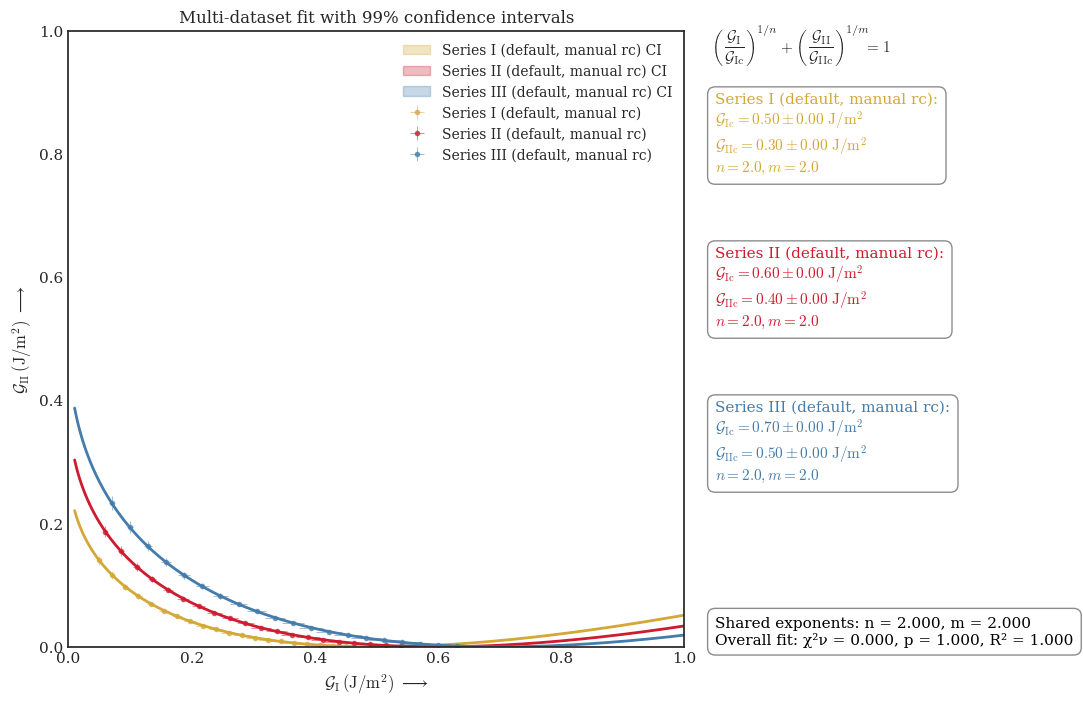

In [27]:
# Example usage with chi-squared statistics
fit_result = results
data_dict_with_ci = {
    'Series I (default, manual rc)': {
        'df': df1,
        'variant': 'B',
        'fit_params': {
            'GIc': fit_result['GIc_1'],
            'GIIc': fit_result['GIIc_1'],
            'n': fit_result['n'],
            'm': fit_result['m']
        },
        'fit_stddev': {
            'GIc': fit_result['stddev_GIc_1'],
            'GIIc': fit_result['stddev_GIIc_1'],
            'n': fit_result['stddev_n'],
            'm': fit_result['stddev_m']
        }
    },
    'Series II (default, manual rc)': {
        'df': df2,
        'variant': 'B',
        'fit_params': {
            'GIc': fit_result['GIc_2'],
            'GIIc': fit_result['GIIc_2'],
            'n': fit_result['n'],
            'm': fit_result['m']
        },
        'fit_stddev': {
            'GIc': fit_result['stddev_GIc_2'],
            'GIIc': fit_result['stddev_GIIc_2'],
            'n': fit_result['stddev_n'],
            'm': fit_result['stddev_m']
        }
    },
    'Series III (default, manual rc)': {
        'df': df3,
        'variant': 'B',
        'fit_params': {
            'GIc': fit_result['GIc_3'],
            'GIIc': fit_result['GIIc_3'],
            'n': fit_result['n'],
            'm': fit_result['m']
        },
        'fit_stddev': {
            'GIc': fit_result['stddev_GIc_3'],
            'GIIc': fit_result['stddev_GIIc_3'],
            'n': fit_result['stddev_n'],
            'm': fit_result['stddev_m']
        }
    },
}

# Add overall fit statistics
overall_stats = {
    'reduced_chi_squared': fit_result['reduced_chi_squared'],
    'p_value': fit_result['p_value'],
    'R_squared': fit_result['R_squared']
}

# Add to first dataset for overall display
data_dict_with_ci[list(data_dict_with_ci.keys())[0]]['overall_fit_stats'] = overall_stats


fig, ax = vis.plot_multiple_interactionlaws_with_fit(
    data_dict_with_ci, 
    save_fig=save_fig_path + "test.png", 
    title="default_manual", 
    Gmax=1.0, 
    colors=colors, ci=0.99
)
plt.show()